In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

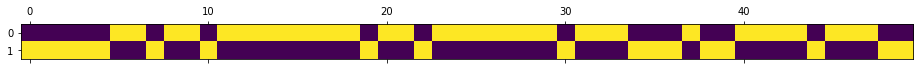

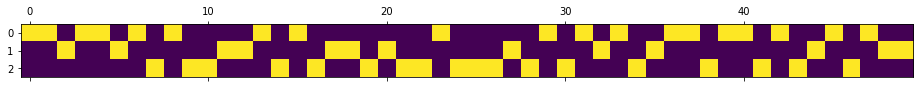

In [13]:
pi=np.array([.8,.2])
A = np.array([[.6, .4, ], [.5, .5]])
Ntimes=50
Nstates=2

def generating_states(pi,A,Ntimes):
    
    Q=np.ones(Ntimes)*-1

    Nstates=np.size(A[:,0])
    
    states = np.zeros((Nstates, Ntimes))
    
    Q[0]=np.random.choice(Nstates,1,p=pi)[0]
    
    states[int(Q[0]),0]=1
    
    for t in range(1, Ntimes):
        
        Q[t]=np.random.choice(Nstates,1,p=A[int(Q[t-1])])[0]
        
        idx=Q[t]
        
        states[int(idx),t]=1
        
    return Q, states


Q, states=generating_states(pi,A,Ntimes)

plt.matshow(states)

B = np.array([[.2, .4, .4], [.5, .4, .1]])

def generating_observations(Q,B):

    Ntimes=np.size(Q)
    
    O=np.ones(Ntimes)*-1
    
    Nstates=np.size(B[:,0])
    
    Nobservations= np.size(B[0,:])
    
    O_mat=np.zeros((Nobservations,Ntimes))
    
    for t in range(Ntimes):
        
        O[t]=np.random.choice(Nobservations,1,p=B[int(Q[t-1])])[0]
        
        O_mat[int(O[t]),t]=1
        
    return O, O_mat
O, O_mat = generating_observations(Q,B)    
plt.matshow(O_mat)    

#Generate observations from the state
#do forward to due to the probabliities


In [30]:
def forward(O, A, B, pi):
    
    T = O.shape[0]
    
    N = A.shape[0]
    
    alpha = np.empty((N, T))# p(z_t|y_{1:T})
    alpha2 = np.empty((N, T))# p(z_t|y_{1:T})
    
    alpha[:,0]=pi*B[:,int(O[0])]
        
    alpha[:,0]=alpha[:,0]/sum(alpha[s,0] for s in range(N))
      
    for t in range(1,T):
        
        asum = sum([sum([alpha[j,t-1]*A[j,s]*B[s,int(O[t])]  for j in range(N)]) for s in range(N)])
        
        for s in range(N):
            
            alpha2[s,t]=sum([alpha[j,t-1]*A[j,s]*B[s,int(O[t])] for j in range(N)])
        
        alpha[:,t]=alpha2[:,t]   
        
        for s in range(N):
            
            alpha[s,t] =alpha[s,t]/asum
        
    forwardprob = np.sum(alpha,0)
        
    logZ = np.log(forwardprob)
    
    return forwardprob, alpha, logZ

def backward(O,A,B):
    T = O.shape[0]
    
    N = A.shape[0]
    
    beta = np.empty((N, T))# p(z_t|y_{1:T})
    beta2 = np.empty((N, T))# p(z_t|y_{1:T})
    beta[:,-1] = 1
            
    beta[:,-1] = beta[:,-1]/sum(beta[s,-1] for s in range(N))
       
    for t in reversed(range(0,T-1)):
        
        bsum=sum([sum([beta[j,t]*A[j,s]*B[s,int(O[t])] for j in range(N)]) for s in range(N)])
        
        for s in range(N):
            
            beta2[s,t-1]=sum([beta[j,t]*A[j,s]*B[s,int(O[t])] for j in range(N)])
            
        beta[:,t-1]=beta2[:,t-1] 
        
        for s in range(N):
            
            beta[s,t-1]=beta[s,t-1]/bsum
            
    backwardprob = np.sum(beta,0)
    
    return backwardprob, beta

def gamma_solver(alpha, beta):
    
    N, T= alpha.shape
    
    gamma = np.empty((N,T))
    
    for t in range(T):
        gamsum=0.0
        for s in range(N):
            
            gamma[s,t] = (alpha[s,t] * beta[s,t])
            
            gamsum +=gamma[s,t]
        
        for s in range(N):
            
            gamma[s,t] =gamma[s,t]/gamsum
     
    return gamma

#   #for t in range(T):
#         #gamsum = 0.0
#         #for m in range(M):
#             gamma[t, m] = alpha[t, m] * beta[t, m]
#             gamsum += gamma[t, m]

#         for m in range(M):
#             gamma[t, m] /= gamsum

def delta_solver(alpha,beta,A,B):

    N, T = alpha.shape
    
    delta = np.empty((N,N,T))
    
    for t in range(T-1):
        
        for s in range(N):
            
            for j in range(N):
                
                delta[s,j,t]= alpha[s,t]*A_guess[s,j]*B_guess[j,int(O[t+1])-1]*beta[j,t+1]/alpha[-1,-1]
                
    deltaprob = np.sum(delta,0)
    
    delta=delta/deltaprob
    
    return delta

def EM(A_guess,B_guess,O,iterate,pi):

    for step in range(iterate):  

        N, Nobservations = B_guess.shape

        T = O.shape[0]

        forwardprob, alpha, logZ = forward(O,A_guess,B_guess, pi)

        backwardprob, beta = backward(O,A_guess,B_guess)
        

        gamma=gamma_solver(alpha,beta)

        delta=delta_solver(alpha,beta,A_guess,B_guess)
        
        for v in range(Nobservations):
            
            for j in range(N):
                
                B_guess[j,v]=sum([gamma[j,t] for t in range(T) if v==O[t]])/sum([gamma[j,t] for t in range(T)])
                
        for s in range(N):
            
            for j in range(N):
                
                 A_guess[s,j]= sum(delta[s,j,t] for t in range(T-1))/sum(np.sum(delta[s,:,t],0) for t in range(T-1))
    
    A=A_guess
    B=B_guess
    return A, B, alpha, beta, gamma, forwardprob

Text(0.5, 1.05, 'Trevors gamma')

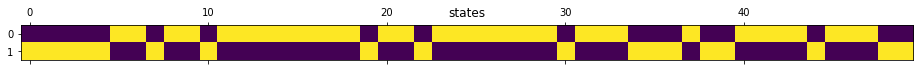

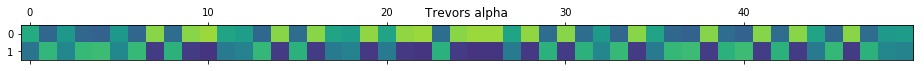

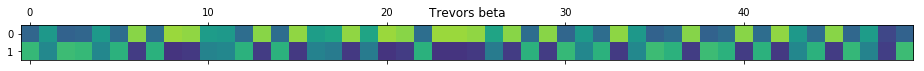

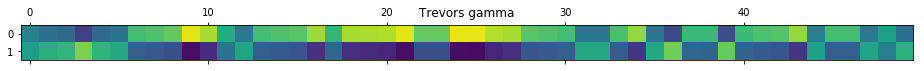

In [31]:
A = np.array([[.6, .4, ], [.5, .5]])
B = np.array([[.2, .4, .4], [.5, .4, .1]])
pi=[.8,.2]


A_New, B_New, alpha4, beta4, gamma, forwardprob =EM(A,B,O,1,pi)

plt.matshow(states)
plt.title('states')
plt.matshow(alpha4, vmin=0,vmax=1)
plt.title('Trevor''s alpha')
plt.matshow(beta4, vmin=0, vmax=1)
plt.title('Trevor''s beta')
plt.matshow(gamma, vmin=0, vmax=1)
plt.title('Trevor''s gamma')

In [33]:
from __future__ import division
import numpy as np
from numba import jit

def fb_infer(A, pi, psi):
    """
    Implement the forward-backward inference algorithm.
    A is a matrix of transition probabilities that acts to the right:
    new_state = A * old_state, so that columns of A sum to 1
    psi is the vector of evidence: p(y_t|z_t); it does not need to be
    normalized, but the lack of normalization will be reflected in logZ
    such that the end result using the given psi will be properly normalized
    when using the returned value of Z
    """
    if np.any(A > 1):
        raise ValueError('Transition matrix probabilities > 1')
    if np.any(pi > 1):
        raise ValueError('Initial state probabilities > 1')

    T = psi.shape[0]
    M = A.shape[0]

    # initialize empty variables
    alpha = np.empty((T, M))  # p(z_t|y_{1:T})
    beta = np.empty((T, M))  # p(y_{t+1:T}|z_t) (unnormalized)
    gamma = np.empty((T, M))  # p(z_t|y_{1:T}) (posterior)
    logZ = np.empty(T)  # log partition function
    Xi = np.empty((T - 1, M, M))

    # initialize
    a = psi[0] * pi
    alpha[0] = a / np.sum(a)
    logZ[0] = np.log(np.sum(a))
    beta[-1, :] = 1
    beta[-1, :] = beta[-1, :] / np.sum(beta[-1, :])

    forward(psi, A, alpha, logZ, a)

    backward(psi, A, beta, a)

    # posterior
    calc_post(alpha, beta, gamma)

    # calculate 2-slice marginal
    two_slice(alpha, beta, psi, A, Xi)

    if np.any(np.isnan(gamma)):
        raise ValueError('NaNs appear in posterior')

    return gamma, np.sum(logZ), Xi

#@jit(nopython=True)
def forward(psi, A, alpha, logZ, a):
    T = psi.shape[0]
    M = A.shape[0]

    for t in range(1, T):
        asum = 0.0
        for i in range(M):
            a[i] = 0.0
            for j in range(M):
                a[i] += psi[t, i] * A[i, j] * alpha[t - 1, j]
            asum += a[i]

        for i in range(M):
            alpha[t, i] = a[i] / asum

        logZ[t] = np.log(asum)
    plt.matshow(alpha.T, vmin=0, vmax=1)
    plt.title('John''s alpha')
#@jit(nopython=True)
def backward(psi, A, beta, a):
    T = psi.shape[0]
    M = A.shape[0]

    for t in range(T - 1, 0, -1):
        asum = 0.0
        for i in range(M):
            a[i] = 0.0
            for j in range(M):
                a[i] += beta[t, j] * psi[t, j] * A[j, i]
            asum += a[i]

        for i in range(M):
            beta[t - 1, i] = a[i] / asum
    plt.matshow(beta.T, vmin=0, vmax=1)
    plt.title('John''s beta')
@jit(nopython=True)
def calc_post(alpha, beta, gamma):
    T, M = alpha.shape

    for t in range(T):
        gamsum = 0.0
        for m in range(M):
            gamma[t, m] = alpha[t, m] * beta[t, m]
            gamsum += gamma[t, m]

        for m in range(M):
            gamma[t, m] /= gamsum

@jit(nopython=True)
def two_slice(alpha, beta, psi, A, Xi):
    T, M = alpha.shape

    for t in range(T - 1):
        xsum = 0.0
        for i in range(M):
            for j in range(M):
                Xi[t, i, j] = beta[t + 1, i] * psi[t + 1, i]
                Xi[t, i, j] *= alpha[t, j] * A[i, j]
                xsum += Xi[t, i, j]

        # normalize
        for i in range(M):
            for j in range(M):
                Xi[t, i, j] /= xsum

Text(0.5, 1.05, 'Trevors gamma')

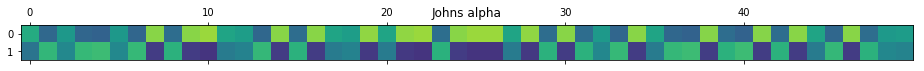

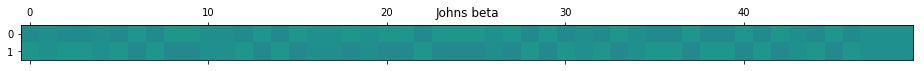

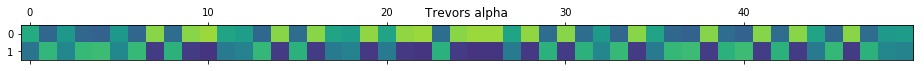

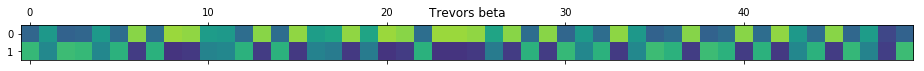

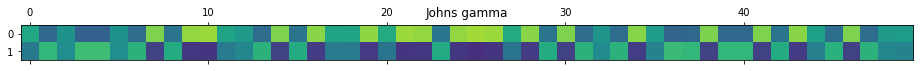

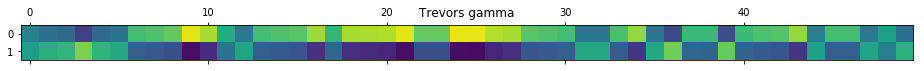

In [35]:
A = np.array([[.6, .4, ], [.5, .5]])
B = np.array([[.2, .4, .4], [.5, .4, .1]])
pi=[.8,.2]
J_gamma, uh2, uh3= fb_infer(np.array(A).T,np.array(pi),np.array(B[:,O.astype(int)]).T)
plt.matshow(alpha4,vmin=0, vmax=1)
plt.title('Trevor''s alpha')
plt.matshow(beta4, vmin=0, vmax=1)
plt.title('Trevor''s beta')
plt.matshow(J_gamma.T, vmin=0, vmax=1)
plt.title('John''s gamma')
plt.matshow(gamma, vmin=0, vmax=1)
plt.title('Trevor''s gamma')



When I added v_min=0 and v_max=1 to your beta on the plot the distinction became more clear as to why alpha seems to dominate the gamma in your fb_infer. But I couldn't figure out why or how yours was different